This tutorial illustrates a simple usage of Loter for local ancestry inference.

## Table of Contents
* [I) Installation](#installation)
* [II) Quick overview](#loter_usage)
* [III) Details about local ancestry inference functions](#details)
* [IV) Dealing with more than 2 ancestral populations](#3pop)

# I) Installation <a class="anchor" id="installation"></a>

To install Loter follow the procedure explained in the [README.md](../README.md) file.
If you have already installed Loter, jump to the [next section](#loter_usage).

# II) Quick overview <a class="anchor" id='loter_usage'></a>

We show here how to perform local ancestry inference using Loter. In this section, we consider haplotypes from diploid admixed individuals. Loter can be used on non-diploid organisms, see [next section](#details).

## a) Haplotype data <a  class="anchor" id='hap_data'></a>

We use human haplotype data generated from the Hapmap dataset (see <https://www.ncbi.nlm.nih.gov/probe/docs/projhapmap/>). In particular, we use haplotypes of the 50,000 first SNPs from both copies of chromosome 1 for individuals sampled from different populations: 44 European individuals (*CEU*), 50 African inviduals (*YRI*) and 23 Mexican individuals (*MEX*).

We detail in the next section how to load data from VCF files.

In [1]:
import os
import numpy as np

H_ceu = np.load(os.path.join(os.pardir, "data", "H_ceu.npy"))
H_yri = np.load(os.path.join(os.pardir, "data", "H_yri.npy"))
H_mex = np.load(os.path.join(os.pardir, "data", "H_mex.npy"))

`H_ceu`, `H_yri` and `H_mex` each represent a matrix of haplotypes sampled from a population (resp. Europe, Africa and Mexico). The matrix $H$ of dimension $(2\times n, p)$ represents the haplotypes of $n$ individuals in rows and $p$ SNPs in columns. In diploid species, there are two haplotypes per individual (hence $2\times n$ haplotypes for $n$ individuals). Haplotype matrices must be encoded with $\{0,1\}$ values. Each entry $H_{ij}$ represents the allele of SNP $j$ in haplotype $i$: 0 being the ancestral allele and 1 the derived (mutated) allele.

In [2]:
H_ceu.shape # CEU haplotypes: 2*44 hapolotypes of the 1st 50,000 SNPs of chromosome 1

(88, 50000)

In [3]:
H_yri.shape # YRI haplotypes: 2*50 hapolotypes of the 1st 50,000 SNPs of chromosome 1

(100, 50000)

In [4]:
H_mex.shape # MEX haplotypes: 2*23 hapolotypes of the 1st 50,000 SNPs of chromosome 1

(46, 50000)

Haplotype matrices are generally obtained as a result of a **phasing algorithm** applied to genotype matrices.

A genotype matrix $G$ of dimension $(n,p)$ represents genotype information regarding $n$ individuals in rows and $p$ SNPs in columns. Genotype matrices are encoded with ${0,1,2}$ values. Each entry $G_{ij}$ represent the alleles of a SNP $j$ on both copies of the corresponding chromosome in individual $i$: 0 = homozygous ancestral, 2 = homozygous mutated, 1 = heterozygous (ancestral on one chromosome and derived on the other).

Data in this example (`H_ceu`, `H_yri` and `H_mex`) are the results of the phasing software [Beagle](https://faculty.washington.edu/browning/beagle/beagle.html) applied to Hapmap data and stored in Numpy array.

## b) Loading data from VCF Files <a  class="anchor" id='load_data_vcf'></a>

Haplotype data are generally stored in VCF format. We show here how lo load data from such files to be used in Loter.

To load a VCF, we use [scikit allel](https://scikit-allel.readthedocs.io/en/latest/#). To install it, you can run `pip install scikit-allel`.

In [5]:
import allel
import numpy as np

`vcf2npy` convert a VCF File to a numpy matrix with values 0, 1 and 2.

In [6]:
def vcf2npy(vcfpath):
    callset = allel.read_vcf(vcfpath)
    haplotypes_1 = callset['calldata/GT'][:,:,0]
    haplotypes_2 = callset['calldata/GT'][:,:,1]
    
    m, n = haplotypes_1.shape
    mat_haplo = np.empty((2*n, m))
    mat_haplo[::2] = haplotypes_1.T
    mat_haplo[1::2] = haplotypes_2.T
    
    return mat_haplo.astype(np.uint8)

These 3 files are the results of the phasing software [Beagle](https://faculty.washington.edu/browning/beagle/beagle.html). Hence, we only get $\{0,1\}$ valued matrices.

In [7]:
import os

H_ceu = vcf2npy(os.path.join(os.pardir, 'data', 'ceu.vcf'))
H_yri = vcf2npy(os.path.join(os.pardir, 'data', 'yri.vcf'))
H_mex = vcf2npy(os.path.join(os.pardir, 'data', 'mex.vcf'))

## c) Run Loter <a class="anchor" id='run_loter'></a>

We run Loter with default parameters.

We assume, in this example, that Mexicans (*MEX*) are the result of an admixture between Europeans and Africans. We use present-day samples from European (*CEU*) and African (*YRI*) populations as a proxy for haplotypes of ancestral populations.

The function `loter.locanc.local_ancestry.loter_smooth` takes at least two arguments (when using default values for the method hyper-parameters):
* `l_H`: a list of "ancestral" or reference haplotypes matrices. Its length is equal to the number of ancestral populations.
* `h_adm`: a matrix of admixed haplotypes

and returns a matrix indicating the origin (regarding the ancetry) of each SNP in each haplotype: each entry $(i,j)$ corresponds to the index of the ancestral population in the list of ancestral haplotypes matrices from which the SNPs $j$ in haplotype $i$ originates (0 for the first population in `l_H` and $1$ for the second population in `l_H`).

**Note:** The function `loter.locanc.local_ancestry.loter_smooth` uses a module that is able to correct phasing error (c.f. [next section](#details)). This module is specifically designed for diploid organism (i.e. that `h_adm` contains an even number of haplotypes).

This computation may take several minutes to complete.

In [8]:
import loter.locanc.local_ancestry as lc

res_loter = lc.loter_smooth(l_H=[H_ceu, H_yri], h_adm=H_mex, num_threads=8) ## set the number of threads

In [9]:
print(res_loter.shape) # 2*23 haplotype and 50000 SNPs 

(46, 50000)


## d) Visualize ancestry chunks <a class="anchor" id='plot_result'></a>

For data visualization, we use the `matplotlib` package. To install it, you can run `pip install matplotlib`.

We display admixture chunks for each admixed haplotypes (in rows) and SNPs (in columns). Chunks of 0 correspond to CEU (first element of the list) and chunks of 1 correspond to YRI (second element of the list).

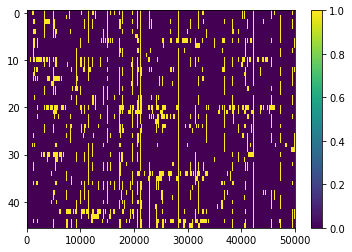

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(res_loter, interpolation='nearest', aspect='auto')
plt.colorbar()

Finally, we can save the result. Each line correspond to an haplotype. The SNPs are space delimited.

In [11]:
np.savetxt("result_mex.txt", res_loter, fmt="%i")

# III) Details about local ancestry inference functions <a class="anchor" id='details'></a>

This section concerns more advanced users that would like to change default parameter values and understand the algorithm behing the local ancestry inference approach in Loter. We recommend to use default function with default parameter values, designed to give the best results for a broad range of species.

All details regarding local ancestry inference can be found in this reference: Dias-Alves, T., Mairal, J., Blum, M.G.B., 2018. Loter: A Software Package to Infer Local Ancestry for a Wide Range of Species. Mol Biol Evol 35, 2318–2326. https://doi.org/10.1093/molbev/msy126

We use the same example as previously.

In [12]:
import os
import numpy as np

H_ceu = np.load(os.path.join(os.pardir, "data", "H_ceu.npy"))
H_yri = np.load(os.path.join(os.pardir, "data", "H_yri.npy"))
H_mex = np.load(os.path.join(os.pardir, "data", "H_mex.npy"))

## a) Loter with phase correction

The algorithm for local ancestry inference in Loter is based on a penalty parameter $\lambda$ (`lambda`). To avoid choosing it, we use a bagging approach: the model is trained for different values of $\lambda$ over mutliple bootstrap resamplings, and the result is determined by a majority vote among the different trained models.

In addition, the standard approach for local ancestry inference in Loter integrates a post-processing step based on a phase correction module, which accounts for phasing error (i.e. switches of homologous loci between the two copies of a chromosome in an individual). The phase correction step corresponds to a smoothing of the bagging results and is specifically designed for data sampled from diploid organisms.

The function `loter.locanc.local_ancestry.loter_smooth` implements the method with both bagging and phase correction. Besides `l_H` and `h_adm` (c.f. [previously](#run_loter)), it takes several additional hyper-parameters:
* `range_lambda`: list or 1-d array of candidate values (>0) for $\lambda$
* `threshold`: smoothing parameter in [0,1] for the phase correction module (=1 corresponds to no smoothing)
* `rate_vote`: bagging vote parameter in [0,1]
* `nb_bagging`: number of resampling in the bagging (positive interger)
* `num_threads`: number of threads for parallel computations (requires OpenMP, c.f. [README.md](../README.md))

In [13]:
import loter.locanc.local_ancestry as lc

res_loter = lc.loter_smooth(l_H=[H_ceu, H_yri], h_adm=H_mex, range_lambda=np.arange(1.5, 5.5, 0.5),
                            threshold=0.90, rate_vote=0.5, nb_bagging=20, num_threads=8)

## b) Loter without phase correction

It is possible to run the local ancestry inference approach in Loter without the phase correction module. To do so, you should use the function `loter.locanc.local_ancestry.loter_local_ancestry`.

Besides `l_H` and `h_adm` (c.f. [previously](#run_loter)), it takes several additional hyper-parameters:
* `range_lambda`: list or 1-d array of candidate values (>0) for $\lambda$
* `rate_vote`: bagging vote parameter in [0,1]
* `nb_bagging`: number of resampling in the bagging (positive interger)
* `num_threads`: number of threads for parallel computations (requires OpenMP, c.f. [README.md](../README.md))

In [14]:
import loter.locanc.local_ancestry as lc

res_loter = lc.loter_local_ancestry(l_H=[H_ceu, H_yri], h_adm=H_mex, range_lambda=np.arange(1.5, 5.5, 0.5),
                                    rate_vote=0.5, nb_bagging=20, num_threads=8)

The result containing haplotypic ancestry can be found in `res_loter`.

In particular, `res_loter[0]` contains the ancestry and `res_loter[1]` contains the number of time that ancestry was picked in the bagging procedure.

Again, we display admixture chunks. Chunks of 0 correspond to CEU (first element of the list) and chunks of 1 correspond to YRI (second element of the list).

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(res_no_impute[0], interpolation='nearest', aspect='auto')
plt.colorbar()

**Note:** The default version of the function `lc.loter_local_ancestry` can be used on non-diploid organisms.

If you want to get additional information about genotypic ancestry, only in the case of diploid organisms, you can change the `default` parameter value:

In [16]:
res_impute, res_no_impute = lc.loter_local_ancestry(l_H=[H_ceu, H_yri], h_adm=H_mex, range_lambda=np.arange(1.5, 5.5, 0.5),\n",
                                                    rate_vote=0.5, nb_bagging=20, num_threads=8, default=False)

In this case, the result containing haplotypic ancestry can be found in the second variable `res_no_impute`. In particular, `res_no_impute[0]` contains the ancestry and `res_no_impute[1]` contains the number of time that ancestry was picked in the bagging procedure.

In addition, `res_impute` contains the genotypic ancestry. The genotypic ancestry corresponds to the paired haplotypic ancestries without order. For instance, if there are 3 ancestral populations, there are 6 possible ancestry values for genotypic ancestry.

Denoting by $h1$ and $h2$ the haplotypic ancestry at a locus, the mapping function is the following:

$$g: (h1, h2) -> (max(h1, h2) * (max(h1, h2) + 1))/2 + min(h1, h2)$$

For example, let's consider 3 populations:
* g((0, 0)) = (0 * 1)/2 + 0 = 0

* g((0, 1)) = g((1, 0)) = (0 * 1)/2 + 1 = 1

* g((1, 1)) = (1 * 2)/2 + 1 = 2

* g((2, 0)) = g((0, 2)) = (2 * 3)/2 + 0 = 3

* g((2, 1)) = g((1, 2)) = (2 * 3)/2 + 1 = 4

* g((2, 2)) = (2 * 3)/2 + 2 = 5

So genotypic ancestry compresses the pair information into one single number.
It is useful for the computation of the genotypic ancestry error rate.


# IV) Dealing with more than 2 ancestral populations <a class="anchor" id='3pop'></a>

It is not currently possible to account for phasing errors in Loter local ancestry inference procedure when there are more than two ancestral populations. Haplotypic length of ancestry tracts will be affected and should not be used when there are more than 2 ancestral populations. Other statistics at the scale of genotypes (mean ancestry in the population, mean ancestry per individual) are accurately inferred.

Thus, you can used the bagging-only procedure `loter.locanc.local_ancestry.loter_local_ancestry` described [previously](#details) (in default mode or not).

Here, we show a toy example where Mexican haplotypes are both the admixed haplotypes and in the reference list.

In [17]:
import loter.locanc.local_ancestry as lc

res_loter = lc.loter_local_ancestry([H_ceu, H_yri, H_mex], H_mex, num_threads=8) ## set the number of threads

See [previous section](#details) for details about the structure of `res_loter`.